# Modelo resuelto con heurísticas

* [Preprocesamiento de datos](#Preprocesamiento-de-datos)
* [Heurísticas](#Heurísticas)

## Preprocesamiento de datos 

In [1]:
import pandas as pd
from gurobipy import *
from pyomo.environ import *

In [71]:
xls = pd.ExcelFile('Proyecto_1_TransporteMaritimo_Dataset2.xlsx', engine='openpyxl')
nombres= xls.sheet_names
df1 = pd.read_excel(xls, nombres[0])
df2 = pd.read_excel(xls, nombres[1])
df3= pd.read_excel(xls, nombres[2])
df4= pd.read_excel(xls, nombres[3])
df5= pd.read_excel(xls, nombres[4])

Se transforman los datos de los dataframes a diccionarios para el procesamiento de datos

In [72]:
barcos_sheet = df1.to_dict("index")
compatibilidad_sheet = df2.to_dict()
cargos_sheet = df3.to_dict("index")
costos_transporte_sheet = df4.to_dict("index")
costos_transporte_dict = {(costos_transporte_sheet[i]['ID_Barco'],costos_transporte_sheet[i]['Puerto_Origen'],costos_transporte_sheet[i]['Puerto_Destino']) : {'Tiempo_Viaje_hrs':costos_transporte_sheet[i]['Tiempo_Viaje_hrs'], 'Costo_Viaje_libras':costos_transporte_sheet[i]['Costo_Viaje_libras']} for i in costos_transporte_sheet.keys()}
costos_tiempo_sheet = df5.to_dict("index")
costos_tiempo_dict = {(costos_tiempo_sheet[i]['ID_Barco'],costos_tiempo_sheet[i]['ID_Cargo']) : {'Tiempo_Origen_hrs':costos_tiempo_sheet[i]['Tiempo_Origen_hrs'], 'Costos_Origen_hrs':costos_tiempo_sheet[i]['Costos_Origen_hrs'], 'Tiempo_Destino_hrs':costos_tiempo_sheet[i]['Tiempo_Destino_hrs'], 'Costos_Destino_hrs':costos_tiempo_sheet[i]['Costos_Destino_hrs']} for i in costos_tiempo_sheet.keys()}

In [73]:
n_cargos = len([cargos_sheet[i]['ID_Cargo'] for i in cargos_sheet.keys() if cargos_sheet[i]['ID_Cargo']>=0])

 La manera en que funcionan los nodos es: los primeros $n$ ($n =$ número de cargos) son los nodos de carga, los siguientes $n$ son los nodos de descarga, los siguientes $v$ ($v =$ número de barcos) son los nodos de origen, y los último v son los nodos de destino.

In [74]:
V = [1+i for i in barcos_sheet.keys()] ## conjunto barcos
n_barcos = len(V)

In [75]:
Kv= {} # conjunto capacidades de barcos
for i in barcos_sheet.keys():
    Kv[barcos_sheet[i]['ID_Barco']] =  barcos_sheet[i]['Capacidad']

In [76]:
# N^P
nodos_carga= [cargos_sheet[i]['ID_Cargo'] for i in cargos_sheet.keys() if cargos_sheet[i]['ID_Cargo']>=0]

#N^D
nodos_descarga= [i+len(nodos_carga) for i in range(1,len(nodos_carga)+1)] ##conjunto nodos de descarga

In [77]:
nodos = {}
for i in range(n_cargos):
    nodos[cargos_sheet[i]['ID_Cargo']] = {'ID_Cargo': cargos_sheet[i]['ID_Cargo'],
                                          'ID_Puerto': cargos_sheet[i]['ID_Puerto_Origen'],
                                          'Tamano': cargos_sheet[i]['Tamano'],
                                          'Costo_SPOT': cargos_sheet[i]['Costo_SPOT'],
                                          'LT': cargos_sheet[i]['LT_Carga'],
                                          'RT': cargos_sheet[i]['RT_Carga']}
    
    nodos[cargos_sheet[i]['ID_Cargo']+n_cargos] = {'ID_Cargo': cargos_sheet[i]['ID_Cargo'],
                                          'ID_Puerto': cargos_sheet[i]['ID_Puerto_Destino'],
                                          'Tamano': cargos_sheet[i]['Tamano'],
                                          'Costo_SPOT': cargos_sheet[i]['Costo_SPOT'],
                                          'LT': cargos_sheet[i]['LT_Descarga'],
                                          'RT': cargos_sheet[i]['RT_Descarga']}
o = {}
d = {}
for v in V:
    o[v] = n_cargos*2+v
    nodos[n_cargos*2+v] = {'Costo_SPOT': 0,
                           'ID_Cargo': 0,
                           'ID_Puerto': barcos_sheet[v-1]['ID_Puerto '],
                           'LT': barcos_sheet[v-1]['Tiempo_Inicio'],
                           'RT': barcos_sheet[v-1]['Tiempo_Inicio'],
                           'Tamano': 0}
    d[v] = n_cargos*2+n_barcos+v
    nodos[n_cargos*2+n_barcos+v] = {'Costo_SPOT': 0,
                                    'ID_Cargo': 0,
                                    'ID_Puerto': 0,
                                    'LT': 100000,
                                    'RT': 100000,
                                    'Tamano': 0}

In [78]:
compatibilidad = {}
for i in V:
    compatibilidad[i] = [int(j) for j in list(df2.loc[i-1])[1:] if j>0]
compatibilidad

Nv = {}
for i in V:
    Nv[i] = []
    for j in nodos.keys():
        if nodos[j]["ID_Cargo"] in compatibilidad[i] or (j == i+n_cargos*2 or j==i+n_cargos*2+len(V)): 
            Nv[i].append(j)

In [79]:
"""import itertools
Av = {}
for v in V:
    Av[v] = list(itertools.permutations(Nv[v],2))
"""
Av={}
indices = []
for v in V:
    Av[v] = [] 
    for i in Nv[v]:
        for j in Nv[v]:
                Av[v].append((i,j))
                indices.append((i,j,v))
indices = tuplelist(indices)

In [80]:
NP_v = {}
for v in V:
    NP_v[v] = [i for i in nodos_carga if i in Nv[v]]

ND_v = {}
for v in V:
    ND_v[v] = [i for i in nodos_descarga if i in Nv[v]]


In [81]:
LT_i = {i:nodos[i]["LT"] for i in nodos.keys()} #lower bounds ventana de tiempo por nodo
RT_i = {i:nodos[i]["RT"] for i in nodos.keys()} #upper bounds ventana de tiempo por nodo


In [82]:
T_ijv={} # tiempo de entre i y j (tiempo de viaje + tiempo de operación en i)
for i in nodos.keys():
    T_ijv[i] = {} 
    for j in nodos.keys():
        T_ijv[i][j] = {} 
        for v in V:
            cargo_i= nodos[i]["ID_Cargo"]
            cargo_j = nodos[j]["ID_Cargo"]
            if i>n_cargos*2+len(V) or j>n_cargos*2+len(V):
                T_ijv[i][j][v] = 0
            else: 
                puerto_origen = nodos[i]["ID_Puerto"]
                puerto_destino = nodos[j]["ID_Puerto"]
                T_ijv[i][j][v] = costos_transporte_dict[v,puerto_origen,puerto_destino]['Tiempo_Viaje_hrs']
                if 0<i<=n_cargos and (i,j) in Av[v]: 
                    T_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Tiempo_Origen_hrs']
                if n_cargos*2>=i>n_cargos and (i,j) in Av[v]:
                    T_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Tiempo_Destino_hrs']
                
                # se les asigna tiempo de operación igual a 0 a los (i,j) que no pertenecen a Av
                # los (i,j) que no pertenecen a Av aún tienen el tiempo entre el puerto de i y j

In [83]:
C_ijv={} # costo de entre i y j (costo de viaje + costo de operación en i)
for i in nodos.keys():
    C_ijv[i] = {} 
    for j in nodos.keys():
        C_ijv[i][j] = {} 
        for v in V:
            cargo_i= nodos[i]["ID_Cargo"]
            cargo_j = nodos[j]["ID_Cargo"]
            if i>n_cargos*2+len(V) or j>n_cargos*2+len(V):
                C_ijv[i][j][v] = 0
            else: 
                puerto_origen = nodos[i]["ID_Puerto"]
                puerto_destino = nodos[j]["ID_Puerto"]
                C_ijv[i][j][v] = costos_transporte_dict[v,puerto_origen,puerto_destino]['Costo_Viaje_libras']
                if i==11 and j==2 and i==1:
                    print(C_ijv[i][j][v])
                if 0<i<=n_cargos and (i,j) in Av[v]:
                    C_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Costos_Origen_hrs']

                if n_cargos*2>=i>n_cargos and (i,j) in Av[v]:
                    C_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Costos_Destino_hrs']

In [84]:
Qj={i:nodos[i]["Tamano"] for i in nodos.keys()}

Cs = {cargos_sheet[i]['ID_Cargo']:cargos_sheet[i]['Costo_SPOT'] for i in cargos_sheet.keys()}

In [85]:
nodos_index = [i for i in nodos.keys()]

## Heurísticas

Se define la función objetivo y las restricciones del modelo

In [86]:
def obj_rule(model):
    return sum(C_ijv[i][j][v]*model.x[i,j,v]  for v in V for (i,j) in Av[v])+sum(Cs[i]*model.y[i] for i in nodos_carga)

def const_1(model, i):
    #return sum(model.x[i,j,v]  for v in V for j in Nv[v]) + model.y[i] == 1
    return sum(model.x[i,j,v]  for v in V for j in Nv[v] if i in Nv[v]) + model.y[i] == 1

def const_2(model, v):
    #return sum(model.x[o[v],j,v] for j in Nv[v]) == 1
    return sum(model.x[o[v],j,v] for j in Nv[v] if o[v]!=j) == 1

def const_3(model, i, v):
    if i in Nv[v]:
        if i!=o[v] and i!=d[v]:
            #return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[j,i,v] for j in Nv[v] if j!=i)==0
            return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[j,i,v] for j in Nv[v])==0
    return Constraint.Skip

def const_4(model, v):
    #return sum(model.x[j,d[v],v] for j in Nv[v]) == 1
    return sum(model.x[j,d[v],v] for j in Nv[v] if d[v]!=j) == 1

def const_5(model, i, j, v):
    if j in NP_v[v]:
        if (i,j) in Av[v]:
            return model.l[i,v]+Qj[j]-model.l[j,v]<=Kv[v]*(1-model.x[i,j,v])
    return Constraint.Skip

def const_6(model, i, j, v):
    if j in NP_v[v]:
        if (i,n_cargos+j) in Av[v]:
            return model.l[i,v]-Qj[j]-model.l[n_cargos+j,v]<=Kv[v]*(1-model.x[i,n_cargos+j,v])
    return Constraint.Skip

def const_7(model, i, v):
    if i in NP_v[v]:
        return (0, model.l[i,v], Kv[v])
    return Constraint.Skip

def const_8(model, i, j, v):
    if (i,j) in Av[v]:
        return model.t[i,v]+T_ijv[i][j][v]-model.t[j,v]<=(RT_i[i]+T_ijv[i][j][v])*(1-model.x[i,j,v])
    return Constraint.Skip

def const_9(model, i, v):
    if i in NP_v[v]:
        #return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[n_cargos+i,j,v] for j in Nv[v] if j!=i+n_cargos)==0
        return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[n_cargos+i,j,v] for j in Nv[v])==0
    return Constraint.Skip

def const_10(model, i, v):
    if i in NP_v[v]:
        return model.t[i,v]+T_ijv[i][n_cargos+i][v]-model.t[n_cargos+i,v]<=0
    return Constraint.Skip
    
def const_11(model, i, v):
    if i in Nv[v]:
        return (LT_i[i], model.t[i,v], RT_i[i])
    return Constraint.Skip

**definir_modelo** retorna una instancia del modelo con sus variables, valor objetivo y restricciones

In [87]:
def definir_modelo():
    #crear modelo
    model_1 = ConcreteModel()
    #definir variables 
    model_1.x = Var(nodos_index, nodos_index, V, within=Binary)
    model_1.y = Var(nodos_carga, within=Binary)
    model_1.t = Var(nodos_index,V)
    model_1.l = Var(nodos_index,V, within=NonNegativeReals)
    #definir VO
    model_1.obj = Objective(rule=obj_rule)
    #definir restricciones
    model_1.const_1 = Constraint(nodos_carga, rule=const_1)
    model_1.const_2 = Constraint(V, rule=const_2)
    model_1.const_3 = Constraint(nodos_index, V, rule=const_3)
    model_1.const_4 = Constraint(V, rule=const_4)
    model_1.const_5 = Constraint(nodos_index, nodos_index, V, rule=const_5)
    model_1.const_6 = Constraint(nodos_index, nodos_index, V, rule=const_6)
    model_1.const_7 = Constraint(nodos_index, V, rule=const_7)
    model_1.const_8 = Constraint(nodos_index, nodos_index, V, rule=const_8)
    model_1.const_9 = Constraint(nodos_index, V, rule=const_9)
    model_1.const_10 = Constraint(nodos_index, V, rule=const_10)
    model_1.const_11 = Constraint(nodos_index, V, rule=const_11)
    return model_1

**random_removal** recibe una instancia del modelo, se eligen $q$ cargos para reasignar, y se fija el resto de las variables asociadas a los cargos restantes.

In [88]:
def random_removal(q, modelo):
    # descomentar la siguente linea para asignar q random
    #q = random.randint(3,7)
    nuevo_modelo = definir_modelo() #se define un nuevo modelo
    cargos_list = random.sample([i for i in range(1, n_cargos+1)],q) #lista de cargos totales
    print(f"cargos reasignados: {cargos_list}")
    for i in nodos_index:
        for j in nodos_index:
            for v in V:
                if modelo.x[i,j,v]() == 1 and not(i in cargos_list) and not(j in cargos_list) and (i<=n_cargos*2 and j<=n_cargos*2):
                    #los barcos que llevaban cargos siguen llevando,
                    # a menos que el cargo que llevaban fuera uno de los elegidos
                    nuevo_modelo.x[i,j,v].setlb(val = 1)
                    nuevo_modelo.x[i,j,v].setub(val = 1)
    for i in range(1, n_cargos+1):
        if modelo.y[i]() == 1 and not(i in cargos_list):
            #los spot que llevaban cargos siguien llevando,
            #a menos que el cargo que llevaban fuera uno de los elegidos
            nuevo_modelo.y[i].setlb(val = 1)
            nuevo_modelo.y[i].setub(val = 1)
    return nuevo_modelo

**creation** recibe una instacia del modelo con las variables fijas y un solver, y resuelve el modelo.

In [89]:
def creation(model, solver):
    solve_time = time.time()
    solver.solve(model)
    values_time = time.time()
    x = model.x.extract_values()
    x_ruta = [i for i in x if x[i] == 1 if (i[0]<=n_cargos*2 and i[1]<=n_cargos*2)]
    y = model.y.extract_values()
    y_spot = [i for i in y if y[i] == 1]
    print("---tiempo values: %s segundos ---" % (time.time() - values_time))
    print("---tiempo solve: %s segundos ---" % (time.time() - solve_time))
    return [x_ruta,y_spot]

In [90]:
def random_removal_2(q, solutions, model, obj_list, q_list):
    cargos_list = random.sample([i for i in range(1, n_cargos+1)],q)
    print("q_list", q_list)
    if obj_list[0] == obj_list[1]:
        print(f"se repitió el resultado obj_list[0]={obj_list[0]} y obj_list[1]={obj_list[1]}")
        for i in cargos_list:
            while i in q_list:
                i = random.randint(1, n_cargos)
    q_list = cargos_list
    print("q_list", q_list)
    cargos_list += [i+n_cargos for i in cargos_list]
    
                
    print(f"cargos reasignados: {cargos_list}")
    set_time = time.time()
    for i in solutions[0]:
        if not(i[0] in cargos_list) and not(i[1] in cargos_list):
            model.x[i].setlb(val = 1)
            model.x[i].setub(val = 1)
        else:
            model.x[i].setlb(val = 0)
            model.x[i].setub(val = 1)
            
    for i in solutions[1]:
        if not(i in cargos_list):
            model.y[i].setlb(val = 1)
            model.y[i].setub(val = 1)
        else:
            model.y[i].setlb(val = 0)
            model.y[i].setub(val = 1)
            
    print("---tiempo for: %s segundos ---" % (time.time() - set_time))
    return model, q_list

## Heurística sin copy

In [100]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np

x_axis = []
y_axis = []
soluciones = []
count = 0
modelo = definir_modelo()
q = 5
q_list = []
obj_list = [-1]
iteraciones = 100
for i in range(n_cargos):
    modelo.y[i+1].setlb(val = 1)
    modelo.y[i+1].setub(val = 1)
solver = SolverFactory('gurobi')
solver.solve(modelo)
obj_list.append(modelo.obj())
x = modelo.x.extract_values()
y = modelo.y.extract_values()
soluciones.append([i for i in x if x[i] == 1 if (i[0]<=n_cargos*2 and i[1]<=n_cargos*2)])
soluciones.append([i for i in y if y[i] == 1])
y_axis.append(modelo.obj())
x_axis.append(count)
start_time = time.time()
while(count<iteraciones):
    iter_time = time.time()
    modelo, q_list = random_removal_2(q, soluciones, modelo, obj_list, q_list)
    soluciones = creation(modelo,solver)
    print(f"obj_list: {obj_list}")
    print(f"valor objetivo: {modelo.obj()}")
    obj_list.append(modelo.obj())
    if len(obj_list)>2:
        obj_list.pop(0)
    print(f"iteración: {count}")
    print("---tiempo iteración: %s segundos ---" % (time.time() - iter_time))
    print("---tiempo LNS: %s segundos ---\n\n" % (time.time() - start_time))
    count += 1
    y_axis.append(modelo.obj())
    x_axis.append(count)

q_list []
q_list [11, 56, 13, 31, 7]
cargos reasignados: [11, 56, 13, 31, 7, 71, 116, 73, 91, 67]
---tiempo for: 0.0005812644958496094 segundos ---
---tiempo values: 0.3014566898345947 segundos ---
---tiempo solve: 29.16363263130188 segundos ---
obj_list: [-1, 48089270.0]
valor objetivo: 43633925.0
iteración: 0
---tiempo iteración: 30.247313261032104 segundos ---
---tiempo LNS: 30.248313665390015 segundos ---


q_list [11, 56, 13, 31, 7, 71, 116, 73, 91, 67]
q_list [9, 23, 40, 41, 48]
cargos reasignados: [9, 23, 40, 41, 48, 69, 83, 100, 101, 108]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.3396885395050049 segundos ---
---tiempo solve: 31.06327986717224 segundos ---
obj_list: [48089270.0, 43633925.0]
valor objetivo: 40653623.0
iteración: 1
---tiempo iteración: 32.224249601364136 segundos ---
---tiempo LNS: 62.93353772163391 segundos ---


q_list [9, 23, 40, 41, 48, 69, 83, 100, 101, 108]
q_list [33, 24, 19, 35, 29]
cargos reasignados: [33, 24, 19, 35, 29, 93, 84, 79, 95, 89]
--

---tiempo values: 0.37276268005371094 segundos ---
---tiempo solve: 30.22642207145691 segundos ---
obj_list: [20881234.0, 20453742.0]
valor objetivo: 20264205.0
iteración: 18
---tiempo iteración: 31.31585717201233 segundos ---
---tiempo LNS: 611.9283399581909 segundos ---


q_list [42, 57, 5, 45, 48, 102, 117, 65, 105, 108]
q_list [26, 34, 22, 36, 32]
cargos reasignados: [26, 34, 22, 36, 32, 86, 94, 82, 96, 92]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.39383554458618164 segundos ---
---tiempo solve: 32.046632051467896 segundos ---
obj_list: [20453742.0, 20264205.0]
valor objetivo: 19154796.0
iteración: 19
---tiempo iteración: 33.16926693916321 segundos ---
---tiempo LNS: 645.6637740135193 segundos ---


q_list [26, 34, 22, 36, 32, 86, 94, 82, 96, 92]
q_list [11, 17, 39, 38, 27]
cargos reasignados: [11, 17, 39, 38, 27, 71, 77, 99, 98, 87]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.4311025142669678 segundos ---
---tiempo solve: 30.971946716308594 segundos ---
obj_list:

---tiempo values: 0.49501514434814453 segundos ---
---tiempo solve: 33.502580881118774 segundos ---
obj_list: [15319116.0, 15319116.0]
valor objetivo: 15319116.0
iteración: 35
---tiempo iteración: 34.68819284439087 segundos ---
---tiempo LNS: 1168.7555377483368 segundos ---


q_list [23, 48, 15, 33, 38, 83, 108, 75, 93, 98]
se repitió el resultado obj_list[0]=15319116.0 y obj_list[1]=15319116.0
q_list [34, 41, 29, 6, 21]
cargos reasignados: [34, 41, 29, 6, 21, 94, 101, 89, 66, 81]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.4169747829437256 segundos ---
---tiempo solve: 31.497895002365112 segundos ---
obj_list: [15319116.0, 15319116.0]
valor objetivo: 15319116.0
iteración: 36
---tiempo iteración: 32.59937334060669 segundos ---
---tiempo LNS: 1202.022747516632 segundos ---


q_list [34, 41, 29, 6, 21, 94, 101, 89, 66, 81]
se repitió el resultado obj_list[0]=15319116.0 y obj_list[1]=15319116.0
q_list [23, 4, 29, 32, 2]
cargos reasignados: [23, 4, 29, 32, 2, 83, 64, 89, 92, 62]
--

---tiempo values: 0.2504265308380127 segundos ---
---tiempo solve: 21.277163982391357 segundos ---
obj_list: [13632468.0, 13632468.0]
valor objetivo: 13632468.0
iteración: 52
---tiempo iteración: 22.214019536972046 segundos ---
---tiempo LNS: 1658.3212666511536 segundos ---


q_list [59, 11, 34, 56, 32, 119, 71, 94, 116, 92]
se repitió el resultado obj_list[0]=13632468.0 y obj_list[1]=13632468.0
q_list [23, 43, 42, 15, 39]
cargos reasignados: [23, 43, 42, 15, 39, 83, 103, 102, 75, 99]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.26586341857910156 segundos ---
---tiempo solve: 22.488852977752686 segundos ---
obj_list: [13632468.0, 13632468.0]
valor objetivo: 13632468.0
iteración: 53
---tiempo iteración: 23.336230993270874 segundos ---
---tiempo LNS: 1682.1369485855103 segundos ---


q_list [23, 43, 42, 15, 39, 83, 103, 102, 75, 99]
se repitió el resultado obj_list[0]=13632468.0 y obj_list[1]=13632468.0
q_list [48, 22, 30, 3, 8]
cargos reasignados: [48, 22, 30, 3, 8, 108, 82, 90, 

q_list [47, 54, 36, 7, 15, 107, 114, 96, 67, 75]
se repitió el resultado obj_list[0]=12115547.0 y obj_list[1]=12115547.0
q_list [14, 51, 13, 27, 34]
cargos reasignados: [14, 51, 13, 27, 34, 74, 111, 73, 87, 94]
---tiempo for: 0.0005664825439453125 segundos ---
---tiempo values: 0.27559447288513184 segundos ---
---tiempo solve: 22.512953281402588 segundos ---
obj_list: [12115547.0, 12115547.0]
valor objetivo: 12115547.0
iteración: 69
---tiempo iteración: 23.46745777130127 segundos ---
---tiempo LNS: 2052.317082643509 segundos ---


q_list [14, 51, 13, 27, 34, 74, 111, 73, 87, 94]
se repitió el resultado obj_list[0]=12115547.0 y obj_list[1]=12115547.0
q_list [51, 34, 40, 28, 19]
cargos reasignados: [51, 34, 40, 28, 19, 111, 94, 100, 88, 79]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.2656252384185791 segundos ---
---tiempo solve: 20.864201307296753 segundos ---
obj_list: [12115547.0, 12115547.0]
valor objetivo: 12115547.0
iteración: 70
---tiempo iteración: 21.861527919769287 segu

---tiempo values: 0.2887899875640869 segundos ---
---tiempo solve: 22.306158542633057 segundos ---
obj_list: [11484763.0, 11484762.0]
valor objetivo: 11484762.0
iteración: 85
---tiempo iteración: 23.13582682609558 segundos ---
---tiempo LNS: 2419.1296355724335 segundos ---


q_list [2, 46, 59, 18, 7, 62, 106, 119, 78, 67]
se repitió el resultado obj_list[0]=11484762.0 y obj_list[1]=11484762.0
q_list [51, 17, 10, 28, 34]
cargos reasignados: [51, 17, 10, 28, 34, 111, 77, 70, 88, 94]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.254518985748291 segundos ---
---tiempo solve: 21.08159041404724 segundos ---
obj_list: [11484762.0, 11484762.0]
valor objetivo: 11484762.0
iteración: 86
---tiempo iteración: 22.026700973510742 segundos ---
---tiempo LNS: 2441.5526270866394 segundos ---


q_list [51, 17, 10, 28, 34, 111, 77, 70, 88, 94]
se repitió el resultado obj_list[0]=11484762.0 y obj_list[1]=11484762.0
q_list [17, 9, 25, 27, 23]
cargos reasignados: [17, 9, 25, 27, 23, 77, 69, 85, 87, 83]

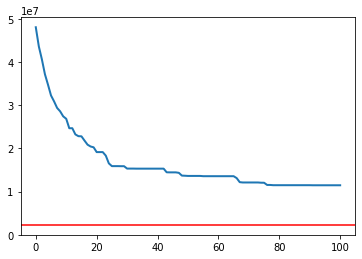

In [101]:
# plot


fig, ax = plt.subplots()
plt.axhline(y=2279204, color='r', linestyle='-')
ax.plot(x_axis, y_axis, linewidth=2.0, label = "LNS")



plt.show()

In [102]:
print("recorrido de barcos")
for i in modelo.x:
    if modelo.x[i].value == 1:
        print(i)
print("\n")
print("cargos asignados a spot")
for i in modelo.y:
    if modelo.y[i].value == 1:
        print(i)

recorrido de barcos
(1.0, 61.0, 12)
(61.0, 19.0, 12)
(2.0, 62.0, 8)
(62.0, 143, 8)
(3.0, 56.0, 15)
(63.0, 116.0, 15)
(4.0, 64.0, 9)
(64.0, 23.0, 9)
(5.0, 14.0, 13)
(65.0, 24.0, 13)
(6.0, 66.0, 5)
(66.0, 35.0, 5)
(7.0, 67.0, 9)
(67.0, 51.0, 9)
(8.0, 68.0, 12)
(68.0, 79.0, 12)
(9.0, 69.0, 7)
(69.0, 17.0, 7)
(11.0, 71.0, 7)
(71.0, 9.0, 7)
(12.0, 72.0, 14)
(72.0, 100.0, 14)
(13.0, 73.0, 8)
(73.0, 15.0, 8)
(14.0, 65.0, 13)
(74.0, 148, 13)
(15.0, 75.0, 8)
(75.0, 2.0, 8)
(16.0, 48.0, 15)
(76.0, 108.0, 15)
(17.0, 110.0, 7)
(77.0, 49.0, 7)
(18.0, 78.0, 11)
(78.0, 27.0, 11)
(19.0, 8.0, 12)
(79.0, 147, 12)
(21.0, 81.0, 9)
(81.0, 4.0, 9)
(22.0, 82.0, 10)
(82.0, 145, 10)
(23.0, 83.0, 9)
(83.0, 26.0, 9)
(24.0, 84.0, 13)
(84.0, 93.0, 13)
(26.0, 86.0, 9)
(86.0, 144, 9)
(27.0, 58.0, 11)
(87.0, 118.0, 11)
(29.0, 89.0, 13)
(89.0, 33.0, 13)
(30.0, 76.0, 15)
(90.0, 63.0, 15)
(31.0, 91.0, 5)
(91.0, 140, 5)
(32.0, 92.0, 14)
(92.0, 40.0, 14)
(33.0, 5.0, 13)
(93.0, 74.0, 13)
(34.0, 94.0, 6)
(94.0, 141, 6)
(35.